In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

import random
import numpy as np
import torch


from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.networks.layers.factories import Act, Norm

from monai.config import print_config
from monai.metrics import DiceMetric
# from src.models.swincspunetr import SwinCSPUNETR
# from src.models.swincspunetr_unet import SwinCSPUNETR_unet
# from src.models.swincspunetr3plus import SwinCSPUNETR3plus

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

# 랜덤 시드 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


print_config()

c:\Users\pook0\.conda\envs\UM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: c:\Users\<username>\.conda\envs\UM\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.19.1+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.17.2
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.

In [2]:
img_size =  96 # Match your patch size
img_depth = img_size
n_classes = 1
batch_size = 16 # 13.8GB GPU memory required for 128x128 img size
loader_batch = 1
num_samples = batch_size // loader_batch # 한 이미지에서 뽑을 샘플 수
num_repeat = 10
# MODEL CONFIG
num_epochs = 4000
lamda = 0.5
ce_weight = 0.4
lr = 0.001
feature_size = 48
use_checkpoint = True
use_v2 = True
drop_rate= 0.2
attn_drop_rate = 0.2
num_bottleneck = 2
# CLASS_WEIGHTS
class_weights = None
# class_weights = torch.tensor([0.0001, 1, 0.001, 1.1, 1, 1.1, 1], dtype=torch.float32)  # 클래스별 가중치
sigma = 1.5
accumulation_steps = 1
# INIT
start_epoch = 0
best_val_loss = float('inf')
best_val_fbeta_score = 0

In [3]:
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch
from pathlib import Path
from monai.networks.nets import UNet
from torch.nn import Sigmoid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=1,
    # dropout = drop_rate,
    norm = Norm.INSTANCE,
    act = Act.PRELU 
).to(device)

pretrain_str = "yes" if use_checkpoint else "no"
weight_str = "weighted" if class_weights is not None else ""

# 체크포인트 디렉토리 및 파일 설정
checkpoint_base_dir = Path("./model_checkpoints")
folder_name = f"Denoising_UNet5_randnoise_{weight_str}_f{feature_size}_d{img_depth}s{img_size}_numb{num_bottleneck}_lr{lr:.0e}_a{lamda:.2f}_b{1-lamda:.2f}_b{batch_size}_r{num_repeat}_ce{ce_weight}_ac{accumulation_steps}"
checkpoint_dir = checkpoint_base_dir / folder_name
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
# 체크포인트 디렉토리 생성
checkpoint_dir.mkdir(parents=True, exist_ok=True)

if checkpoint_dir.exists():
    best_model_path = checkpoint_dir / 'best_model.pt'
    if best_model_path.exists():
        print(f"기존 best model 발견: {best_model_path}")
        try:
            checkpoint = torch.load(best_model_path, map_location=device)
            # 체크포인트 내부 키 검증
            required_keys = ['model_state_dict', 'optimizer_state_dict', 'epoch', 'best_val_loss']
            if all(k in checkpoint for k in required_keys):
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch']
                best_val_loss = checkpoint['best_val_loss']
                print("기존 학습된 가중치를 성공적으로 로드했습니다.")
                checkpoint= None
            else:
                raise ValueError("체크포인트 파일에 필요한 key가 없습니다.")
        except Exception as e:
            print(f"체크포인트 파일을 로드하는 중 오류 발생: {e}")

기존 best model 발견: model_checkpoints\Denoising_UNet5_randnoise__f48_d96s96_numb2_lr1e-03_a0.50_b0.50_b16_r10_ce0.4_ac1\best_model.pt
기존 학습된 가중치를 성공적으로 로드했습니다.


C:\Users\pook0\AppData\Local\Temp\ipykernel_19352\3078735186.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=devic

In [4]:
torch.backends.cudnn.benchmark = True

In [6]:
import numpy as np
import torch
from pathlib import Path
from tqdm import tqdm
import torch.optim as optim
from monai.inferers import sliding_window_inference

wbp_dir = Path("./datasets\wbp\images")

# 슬라이딩 윈도우 함수 정의
def sliding_window_denoising(model, image, roi_size, sw_batch_size, overlap, device):
    model.eval()
    with torch.no_grad():
        image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).float().to(device)
        denoised_image = sliding_window_inference(
            inputs=image_tensor,
            roi_size=roi_size,
            sw_batch_size=sw_batch_size,
            predictor=model,
            overlap=overlap
        )
        denoised_image = denoised_image.squeeze().cpu().numpy()
    return denoised_image


roi_size = (img_depth, img_size, img_size)  # 슬라이딩 윈도우 크기
sw_batch_size = 4  # 슬라이딩 윈도우 배치 크기
overlap = 0.25  # 슬라이딩 윈도우 오버랩 비율

output_dir = Path('./denoised_output')
output_dir.mkdir(parents=True, exist_ok=True)

# 모든 npy 파일에 대해 denoising 수행
for npy_file in tqdm(list(wbp_dir.glob('*.npy')), desc='Denoising'):
    # npy 파일 불러오기
    image = np.load(npy_file)
    
    # 슬라이딩 윈도우 방식으로 denoising 수행
    denoised_image = sliding_window_denoising(model, image, roi_size, sw_batch_size, overlap, device)
    
    # 결과 저장
    output_path = output_dir / npy_file.name
    np.save(output_path, denoised_image)
    print(f"Saved denoised image to {output_path}")

<>:8: SyntaxWarning: invalid escape sequence '\w'
<>:8: SyntaxWarning: invalid escape sequence '\w'
C:\Users\pook0\AppData\Local\Temp\ipykernel_19352\3575931964.py:8: SyntaxWarning: invalid escape sequence '\w'
  wbp_dir = Path("./datasets\wbp\images")
Denoising:   4%|▎         | 1/27 [00:08<03:40,  8.50s/it]

Saved denoised image to denoised_output\wbp_TS_0.npy


Denoising:   7%|▋         | 2/27 [00:10<01:57,  4.70s/it]

Saved denoised image to denoised_output\wbp_TS_1.npy


Denoising:  11%|█         | 3/27 [00:12<01:23,  3.47s/it]

Saved denoised image to denoised_output\wbp_TS_10.npy


Denoising:  15%|█▍        | 4/27 [00:14<01:05,  2.86s/it]

Saved denoised image to denoised_output\wbp_TS_11.npy


Denoising:  19%|█▊        | 5/27 [00:16<00:56,  2.58s/it]

Saved denoised image to denoised_output\wbp_TS_12.npy


Denoising:  22%|██▏       | 6/27 [00:18<00:50,  2.39s/it]

Saved denoised image to denoised_output\wbp_TS_13.npy


Denoising:  26%|██▌       | 7/27 [00:20<00:46,  2.30s/it]

Saved denoised image to denoised_output\wbp_TS_14.npy


Denoising:  30%|██▉       | 8/27 [00:22<00:42,  2.23s/it]

Saved denoised image to denoised_output\wbp_TS_15.npy


Denoising:  33%|███▎      | 9/27 [00:24<00:39,  2.17s/it]

Saved denoised image to denoised_output\wbp_TS_16.npy


Denoising:  37%|███▋      | 10/27 [00:26<00:36,  2.13s/it]

Saved denoised image to denoised_output\wbp_TS_17.npy


Denoising:  41%|████      | 11/27 [00:28<00:33,  2.10s/it]

Saved denoised image to denoised_output\wbp_TS_18.npy


Denoising:  44%|████▍     | 12/27 [00:31<00:31,  2.13s/it]

Saved denoised image to denoised_output\wbp_TS_19.npy


Denoising:  48%|████▊     | 13/27 [00:33<00:29,  2.11s/it]

Saved denoised image to denoised_output\wbp_TS_2.npy


Denoising:  52%|█████▏    | 14/27 [00:35<00:27,  2.12s/it]

Saved denoised image to denoised_output\wbp_TS_20.npy


Denoising:  56%|█████▌    | 15/27 [00:37<00:25,  2.11s/it]

Saved denoised image to denoised_output\wbp_TS_21.npy


Denoising:  59%|█████▉    | 16/27 [00:39<00:23,  2.10s/it]

Saved denoised image to denoised_output\wbp_TS_22.npy


Denoising:  63%|██████▎   | 17/27 [00:41<00:21,  2.12s/it]

Saved denoised image to denoised_output\wbp_TS_23.npy


Denoising:  67%|██████▋   | 18/27 [00:43<00:18,  2.11s/it]

Saved denoised image to denoised_output\wbp_TS_24.npy


Denoising:  70%|███████   | 19/27 [00:45<00:16,  2.06s/it]

Saved denoised image to denoised_output\wbp_TS_25.npy


Denoising:  74%|███████▍  | 20/27 [00:47<00:14,  2.02s/it]

Saved denoised image to denoised_output\wbp_TS_26.npy


Denoising:  78%|███████▊  | 21/27 [00:49<00:11,  1.99s/it]

Saved denoised image to denoised_output\wbp_TS_3.npy


Denoising:  81%|████████▏ | 22/27 [00:51<00:09,  2.00s/it]

Saved denoised image to denoised_output\wbp_TS_4.npy


Denoising:  85%|████████▌ | 23/27 [00:53<00:07,  1.99s/it]

Saved denoised image to denoised_output\wbp_TS_5.npy


Denoising:  89%|████████▉ | 24/27 [00:55<00:06,  2.01s/it]

Saved denoised image to denoised_output\wbp_TS_6.npy


Denoising:  93%|█████████▎| 25/27 [00:57<00:04,  2.04s/it]

Saved denoised image to denoised_output\wbp_TS_7.npy


Denoising:  96%|█████████▋| 26/27 [00:59<00:02,  2.03s/it]

Saved denoised image to denoised_output\wbp_TS_8.npy


Denoising: 100%|██████████| 27/27 [01:01<00:00,  2.29s/it]

Saved denoised image to denoised_output\wbp_TS_9.npy


Visualizing:   0%|          | 0/27 [00:00<?, ?it/s]

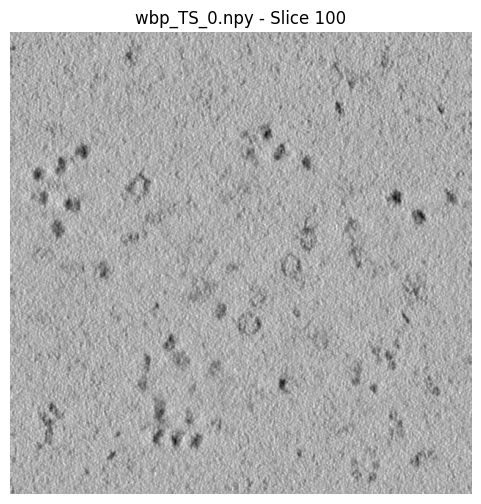

Visualizing:   4%|▎         | 1/27 [00:00<00:06,  4.27it/s]

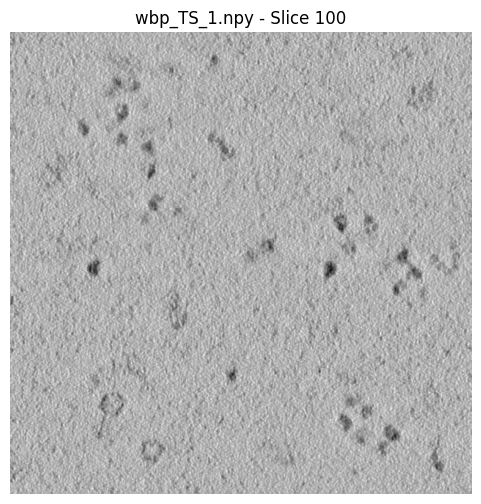

Visualizing:   7%|▋         | 2/27 [00:00<00:06,  3.99it/s]

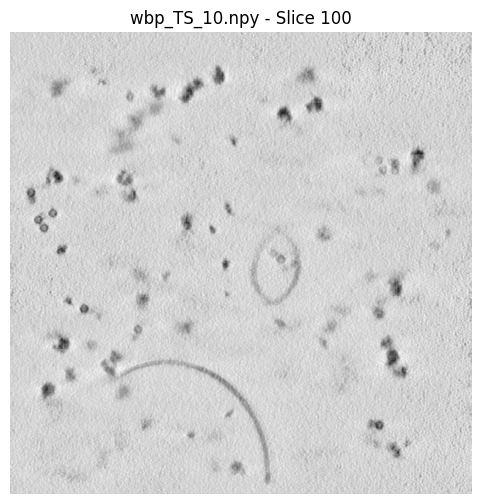

Visualizing:  11%|█         | 3/27 [00:00<00:05,  4.21it/s]

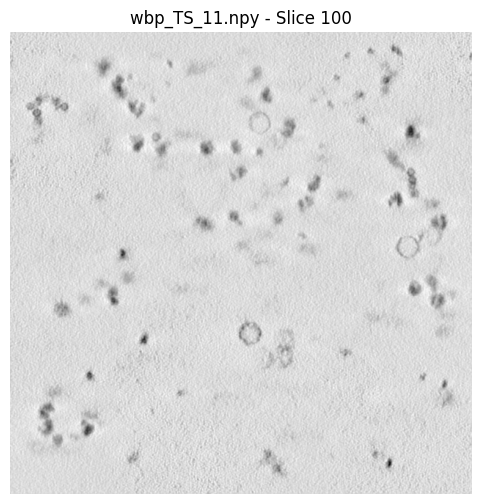

Visualizing:  15%|█▍        | 4/27 [00:00<00:05,  4.28it/s]

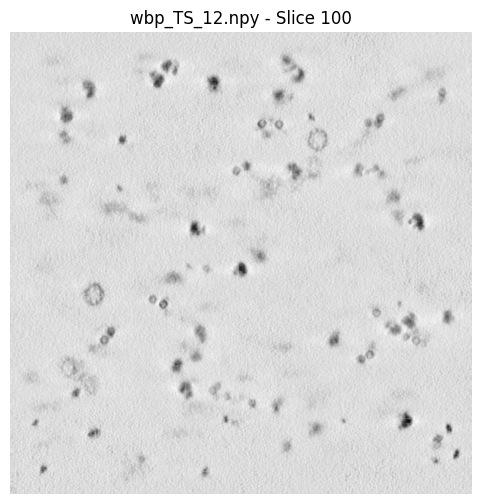

Visualizing:  19%|█▊        | 5/27 [00:01<00:05,  4.16it/s]

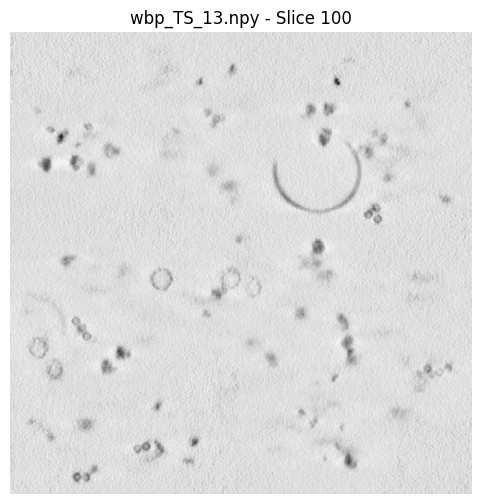

Visualizing:  22%|██▏       | 6/27 [00:01<00:05,  4.18it/s]

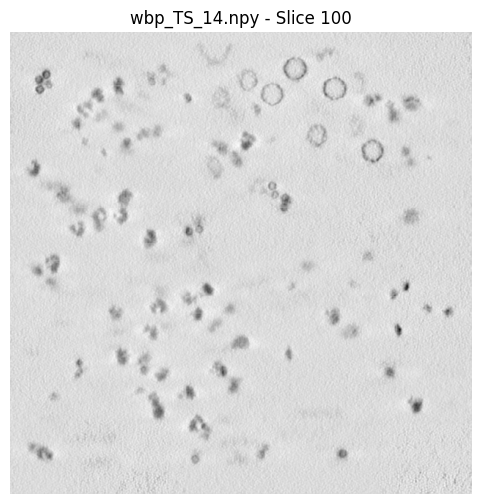

Visualizing:  26%|██▌       | 7/27 [00:01<00:04,  4.23it/s]

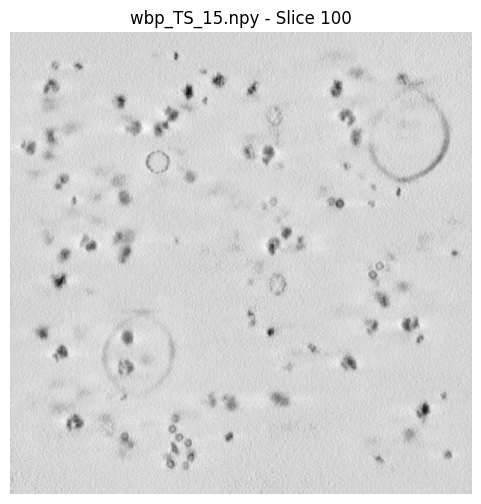

Visualizing:  30%|██▉       | 8/27 [00:01<00:04,  4.06it/s]

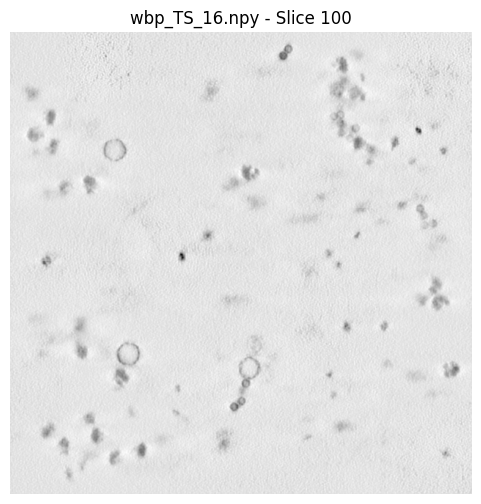

Visualizing:  33%|███▎      | 9/27 [00:02<00:04,  4.10it/s]

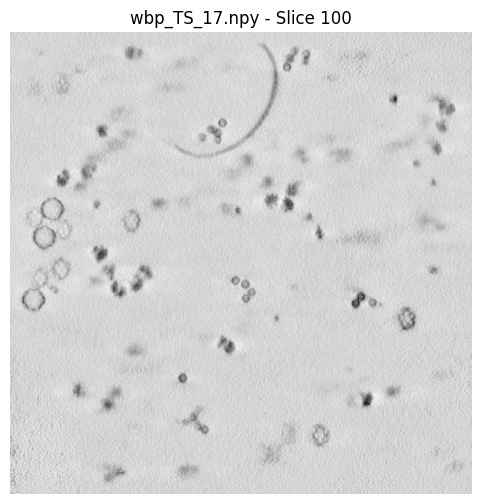

Visualizing:  37%|███▋      | 10/27 [00:02<00:04,  4.14it/s]

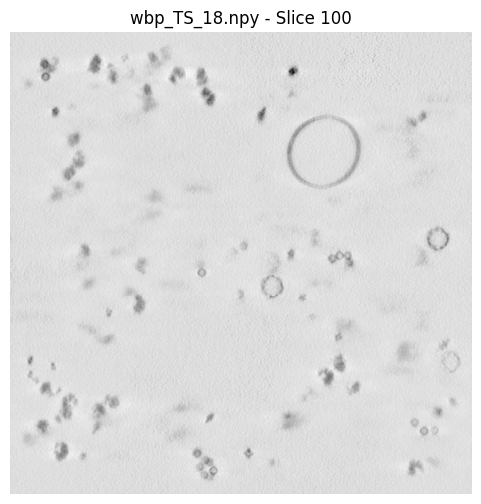

Visualizing:  41%|████      | 11/27 [00:02<00:03,  4.08it/s]

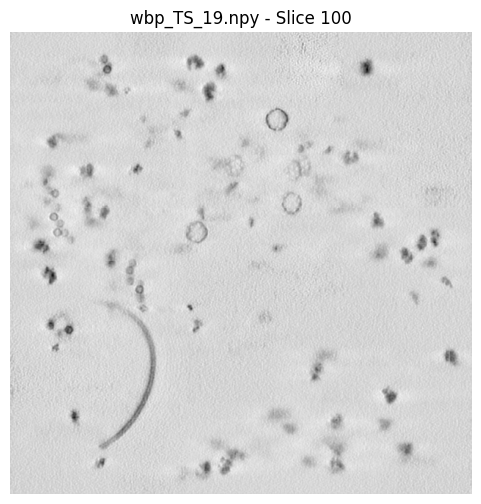

Visualizing:  44%|████▍     | 12/27 [00:02<00:03,  4.04it/s]

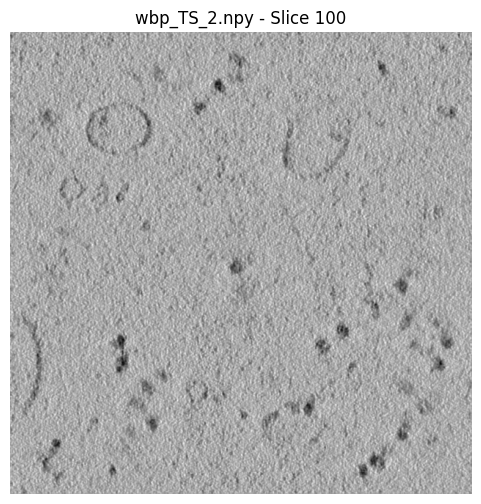

Visualizing:  48%|████▊     | 13/27 [00:03<00:03,  3.96it/s]

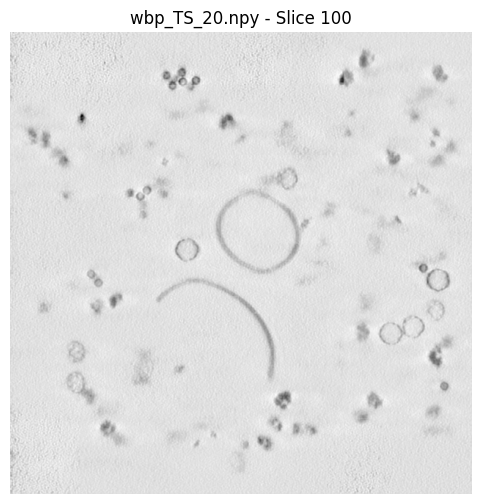

Visualizing:  52%|█████▏    | 14/27 [00:03<00:03,  4.06it/s]

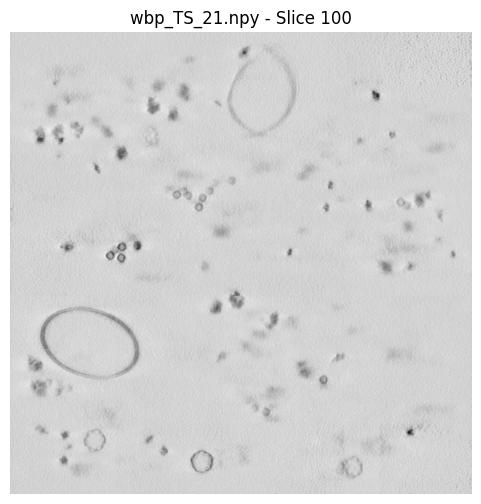

Visualizing:  56%|█████▌    | 15/27 [00:03<00:02,  4.01it/s]

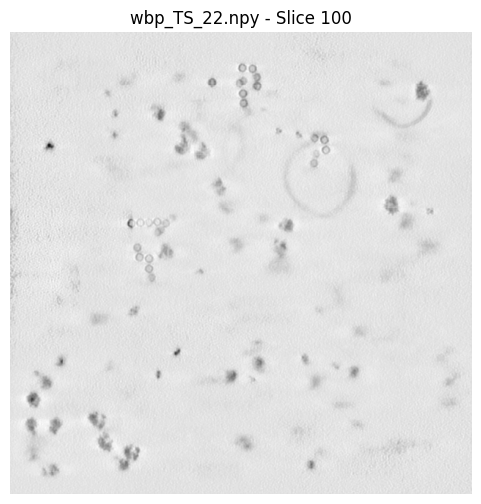

Visualizing:  59%|█████▉    | 16/27 [00:03<00:02,  4.09it/s]

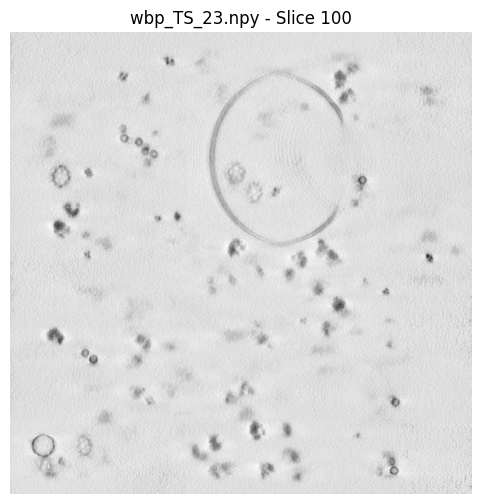

Visualizing:  63%|██████▎   | 17/27 [00:04<00:02,  4.05it/s]

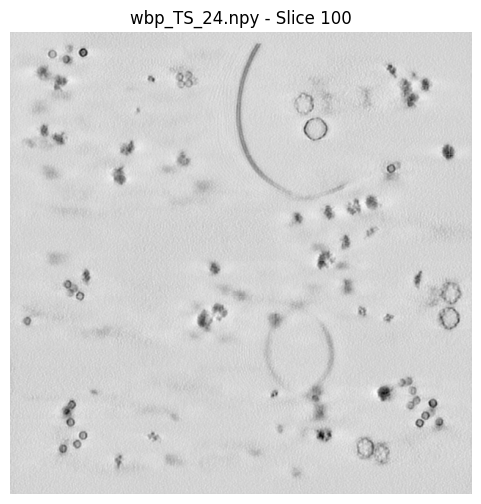

Visualizing:  67%|██████▋   | 18/27 [00:04<00:02,  4.10it/s]

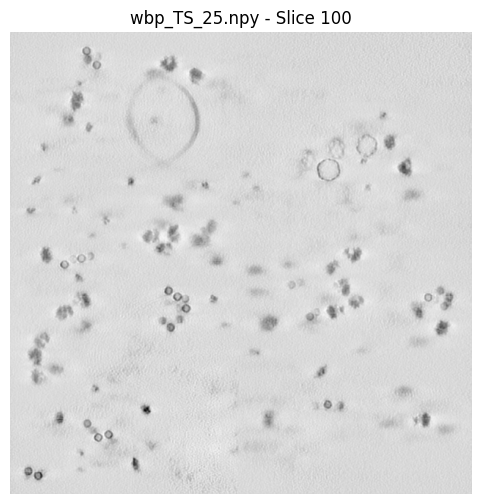

Visualizing:  70%|███████   | 19/27 [00:04<00:01,  4.03it/s]

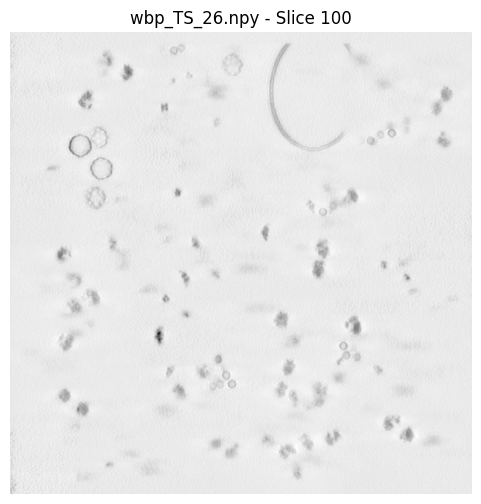

Visualizing:  74%|███████▍  | 20/27 [00:04<00:01,  4.11it/s]

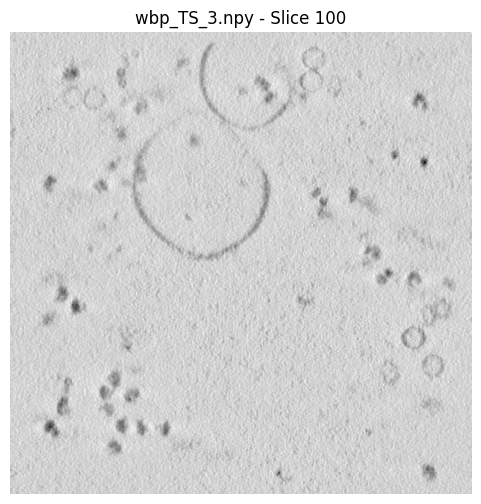

Visualizing:  78%|███████▊  | 21/27 [00:05<00:01,  3.84it/s]

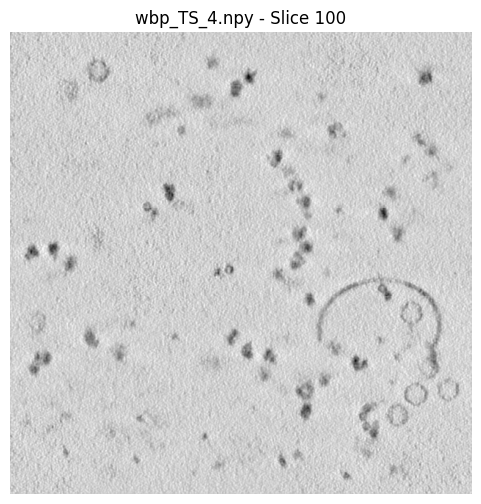

Visualizing:  81%|████████▏ | 22/27 [00:05<00:01,  3.91it/s]

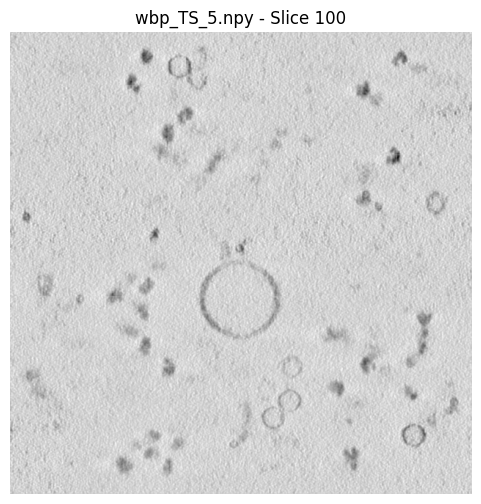

Visualizing:  85%|████████▌ | 23/27 [00:05<00:01,  3.85it/s]

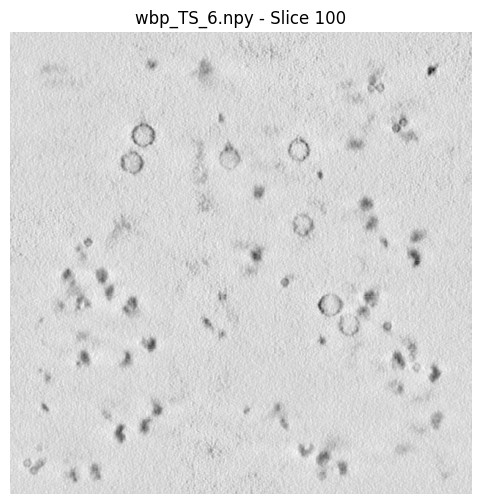

Visualizing:  89%|████████▉ | 24/27 [00:05<00:00,  3.91it/s]

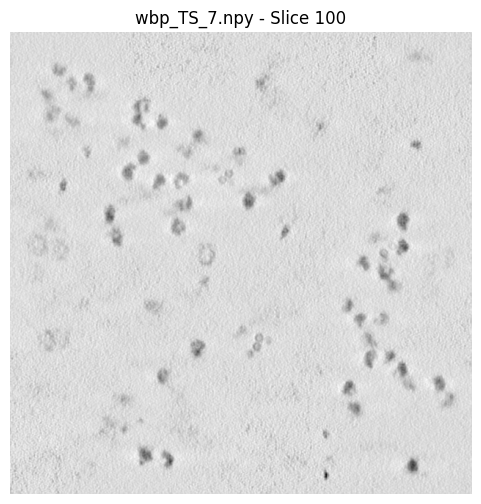

Visualizing:  93%|█████████▎| 25/27 [00:06<00:00,  3.89it/s]

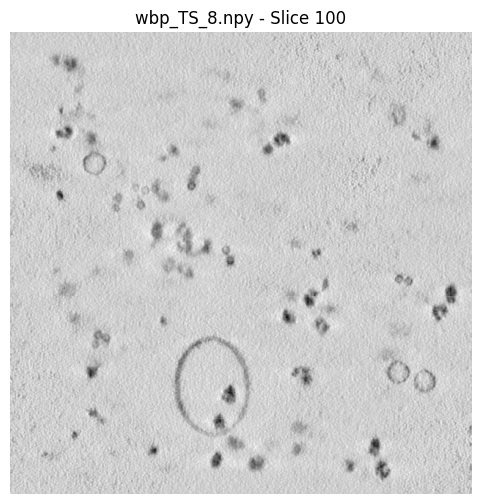

Visualizing:  96%|█████████▋| 26/27 [00:06<00:00,  3.97it/s]

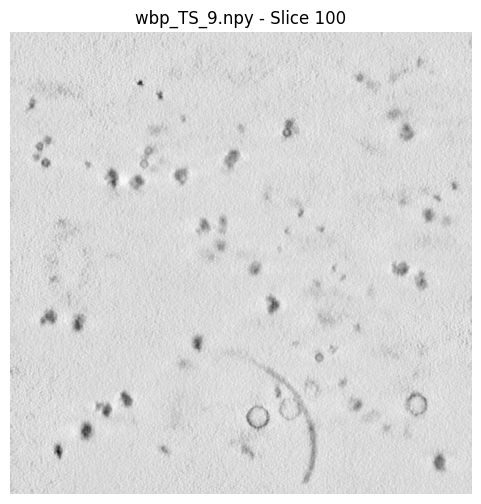

Visualizing: 100%|██████████| 27/27 [00:06<00:00,  4.02it/s]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# 데이터 디렉토리 설정
output_dir = Path('./denoised_output')

# 모든 npy 파일 불러오기
npy_files = list(output_dir.glob('*.npy'))

# 시각화할 파일 수 설정
num_files_to_visualize = len(npy_files)

# 시각화
for npy_file in tqdm(npy_files[:num_files_to_visualize], desc='Visualizing'):
    # npy 파일 불러오기
    denoised_image = np.load(npy_file)
    
    # 중간 z 값 슬라이스 계산
    mid_z = denoised_image.shape[0] // 2
    
    # 시각화
    plt.figure(figsize=(6, 6))
    plt.imshow(denoised_image[mid_z], cmap='gray')
    plt.title(f'{npy_file.name} - Slice {mid_z}')
    plt.axis('off')
    plt.show()